# Train CTRNN
This notebook demonstrates how to use the functions in `ctrnn_jax.training` to train the `CTRNNCell` module on the `SineWaveGenerator` task.

## Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn

from ctrnn_jax.model import CTRNNCell
from ctrnn_jax.tasks import SineWaveGenerator
from ctrnn_jax.training import create_train_state, train_step, compute_metrics

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
key = random.PRNGKey(0)

## Configure model

In [3]:
hidden_features = 100
output_features = 1
alpha = jnp.float32(0.1)
noise_const = jnp.float32(0.1)

In [4]:
ctrnn = nn.RNN(
    CTRNNCell(
        hidden_features=hidden_features,
        output_features=output_features,
        alpha=alpha, 
        noise_const=noise_const,
    ), 
    split_rngs={'params': False, 'noise_stream': True}
)

## Configure `SineWaveGenerator` task

In [5]:
frequencies = jnp.arange(0.1, 0.5, 0.001)
time = 50
batch_size = 8

In [6]:
key, task_key = random.split(key, num=2)
dataset = SineWaveGenerator(task_key, frequencies, time)

In [7]:
tf_dataset_train = dataset.generate_tf_dataset(batch_size)

## Train model

In [8]:
epochs = 1000
metrics_history = {
    'train_loss': [], 
    'train_accuracy': [],
}

learning_rate = 10E-4
init_array = jnp.ones([1, 10, 1])

In [9]:
key, train_state_key = random.split(key, num=2)
train_state = create_train_state(
    train_state_key, 
    ctrnn, 
    learning_rate, 
    init_array,
)

In [10]:
for epoch in tqdm(range(epochs)):

    for _, batch in enumerate(tf_dataset_train.as_numpy_iterator()):
        key, train_key, metrics_key = random.split(key, num=3)
        train_state = train_step(train_key, train_state, batch,)
        train_state = compute_metrics(metrics_key, train_state, batch,)

    for metric, value in train_state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value.item())
        
    train_state = train_state.replace(metrics=train_state.metrics.empty())

100%|███████████████████████████████████████| 1000/1000 [02:26<00:00,  6.84it/s]


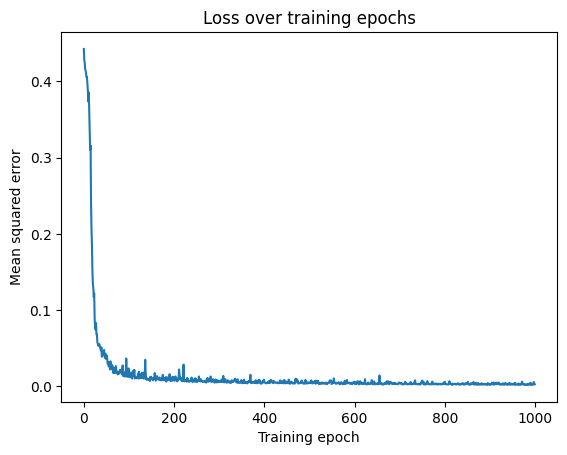

In [11]:
plt.plot(jnp.arange(epochs), metrics_history['train_loss'])
plt.title('Loss over training epochs')
plt.xlabel('Training epoch')
plt.ylabel('Mean squared error')
plt.show()